<a href="https://colab.research.google.com/github/alexandrastna/AI-for-ESG/blob/main/Notebooks/9_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Thesis 9 - ESG Scores computations

The goal of this notebook is to calculate and compare 10 different ESG scores for a set of companies, based on sentence-level classifications extracted from their reports and earnings calls. Each method reflects a different analytical logic or focus.

🔟 The 10 ESG Scoring Methods

1. ***df1*: ESG Quantity**	- Share of ESG sentences (E, S, G) over all sentences; equal weight (divided by 3).
2.	***df2*: ESG Quantity with SASB** - Same as Method 1, but E, S, G are weighted using SASB industry materiality weights.
3.	***df3*: ESG in Earnings Calls** -	Same as Method 1 but only using sentences from earnings calls (normalized accordingly).
4.	***df4*: ESG Earnings Calls with SASB** -	Method 3 + SASB weighting.
5.	***df5*: ESG in Key Communication Docs** -	Method 1 but using only sentences from Earnings / Annual / Integrated / Half-Year reports.
6.	***df6*: Key Docs with SASB**	- Method 5 + SASB weighting.
7.	***df7*: Net Pos-Neg (E-S-G)**	- For each ESG pillar: (Positive - Negative) / Total ESG sentences.
8.	***df8*: Net Pos-Neg with SASB** -	Method 7 + SASB weighting.
9.	***df9*: Positive Only ESG**	- For each ESG pillar: Positive ESG sentences / Total ESG sentences (no negation).
10.	***df10*: Positive Only with SASB** -	Method 9 + SASB weighting.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [37]:
# Load ESG Classification Data
import pandas as pd

# Load the ESG-classified sentences
df_esg = pd.read_csv('/content/drive/MyDrive/Thèse Master/Exports2/df_esg_with_batch_results.csv')

# Load the full classified sentences file to get total phrase counts (ESG or not)
df_all = pd.read_csv('/content/drive/MyDrive/Thèse Master/Exports2/classified_all_sentences.csv')

# Load SASB weights with hybrid alpha included
sasb_path = "/content/drive/MyDrive/Thèse Master/Data/SMI companies.xlsx"
df_weights = pd.read_excel(sasb_path, sheet_name="SASB")

Verifications :

In [38]:
# 🔍 Inspect sentence counts and column names

print("✅ df_esg (ESG-classified sentences)")
print(f"Number of rows: {len(df_esg)}")
print("Columns:", df_esg.columns.tolist())
print("\n")

print("✅ df_all (All classified sentences)")
print(f"Number of rows: {len(df_all)}")
print("Columns:", df_all.columns.tolist())
print("\n")

print("✅ df_weights (SASB weights with hybrid alpha)")
print(f"Number of rows: {len(df_weights)}")
print("Columns:", df_weights.columns.tolist())


✅ df_esg (ESG-classified sentences)
Number of rows: 47272
Columns: ['company', 'year', 'document_type', 'sentence', 'label_env', 'score_env', 'label_soc', 'score_soc', 'label_gov', 'score_gov', 'label_dominant', 'sentiment_gpt_batch']


✅ df_all (All classified sentences)
Number of rows: 201247
Columns: ['company', 'year', 'document_type', 'sentence', 'label_env', 'score_env', 'label_soc', 'score_soc', 'label_gov', 'score_gov', 'label_dominant']


✅ df_weights (SASB weights with hybrid alpha)
Number of rows: 15
Columns: ['company', 'SASB Industry', 'E Topics', '# E Topics', 'S Topics', '# S Topics', 'G Topics', '# G Topics', 'Total', 'E Weight', 'S Weight', 'G Weight', 'verification 1', 'Equal Weights', 'Hybrid E', 'Hybrid S', 'Hybrid G', 'alpha', 'verification 2']


In [39]:
print("df_esg companies:", sorted(df_esg['company'].unique()))
print("df_all companies:", sorted(df_all['company'].unique()))

print("df_esg years:", sorted(df_esg['year'].unique()))
print("df_all years:", sorted(df_all['year'].unique()))



df_esg companies: ['ABB Ltd', 'Compagnie Financière Richemont', 'Holcim Ltd', 'Lonza Group AG', 'Nestlé SA', 'Novartis AG', 'Roche Holding AG', 'Swiss Re Ltd', 'UBS Group AG', 'Zurich Insurance Group AG']
df_all companies: ['ABB Ltd', 'Compagnie Financière Richemont', 'Holcim Ltd', 'Lonza Group AG', 'Nestlé SA', 'Novartis AG', 'Roche Holding AG', 'Swiss Re Ltd', 'UBS Group AG', 'Zurich Insurance Group AG']
df_esg years: [np.int64(2021), np.int64(2022), np.int64(2023)]
df_all years: [np.int64(2021), np.int64(2022), np.int64(2023)]


In [40]:
print("df_esg types:\n", df_esg[['company', 'year']].dtypes)
print("df_all types:\n", df_all[['company', 'year']].dtypes)


df_esg types:
 company    object
year        int64
dtype: object
df_all types:
 company    object
year        int64
dtype: object


In [41]:
print(df_esg['label_dominant'].unique())

['environmental' 'social' 'governance']


1- Common Prerequisites for All Methods

In [42]:
# Normalize to lowercase and strip spaces (in case)
df_esg['label_dominant'] = df_esg['label_dominant'].str.strip().str.lower()

# Keep only ESG-labeled rows
df_esg = df_esg[df_esg['label_dominant'].isin(['environmental', 'social', 'governance'])]

# Flags for ESG dimensions
df_esg['is_env'] = df_esg['label_dominant'] == 'environmental'
df_esg['is_soc'] = df_esg['label_dominant'] == 'social'
df_esg['is_gov'] = df_esg['label_dominant'] == 'governance'

# Sentiment flags
df_esg['is_pos'] = df_esg['sentiment_gpt_batch'] == 'positive'
df_esg['is_neg'] = df_esg['sentiment_gpt_batch'] == 'negative'

# Total sentence count (for normalization)
df_total = df_all.groupby(['company', 'year']).size().reset_index(name='total_sentences')

# Extract SASB weights
df_weights = df_weights.rename(columns={'Company': 'company'})
df_sasb = df_weights[['company', 'Hybrid E', 'Hybrid S', 'Hybrid G']]


In [43]:
print(df_esg['label_dominant'].unique())
print(df_esg['company'].unique())
print(df_esg['year'].unique())


['environmental' 'social' 'governance']
['ABB Ltd' 'Holcim Ltd' 'Lonza Group AG' 'Roche Holding AG' 'UBS Group AG'
 'Novartis AG' 'Zurich Insurance Group AG' 'Swiss Re Ltd'
 'Compagnie Financière Richemont' 'Nestlé SA']
[2023 2022 2021]


In [71]:
import matplotlib.pyplot as plt

def plot_esg_scores(df_scores, year, title='ESG Scores', column='ESG_total'):
    """
    Visualizes ESG scores for a given year, sorted by descending value.

    Parameters:
        df_scores : DataFrame containing at least ['company', 'year', column]
        year : the year to display (e.g., 2022)
        title : the chart title
        column : the name of the ESG score column to display (default is 'ESG_total')
    """
    df_plot = df_scores[df_scores['year'] == year].copy()
    df_plot = df_plot.sort_values(by=column, ascending=False)

    plt.figure(figsize=(10, 5))
    plt.barh(df_plot['company'], df_plot[column], color='skyblue')
    plt.xlabel('Score')
    plt.title(f'{title} – {year}')
    plt.gca().invert_yaxis()  # Puts the company with the highest score at the top
    plt.tight_layout()
    plt.show()


Method 1 – Raw Score (Proportion of ESG / Total Sentences)

In [59]:
# Count ESG sentences per pillar
df_counts = df_esg.groupby(['company', 'year']).agg({
    'is_env': 'sum',
    'is_soc': 'sum',
    'is_gov': 'sum'
}).reset_index()

# Merge with total sentence count
df1 = df_counts.merge(df_total, on=['company', 'year'], how='left')

# Calculate raw ESG scores
df1['E_score'] = df1['is_env'] / df1['total_sentences']
df1['S_score'] = df1['is_soc'] / df1['total_sentences']
df1['G_score'] = df1['is_gov'] / df1['total_sentences']

# ESG total score without weight, normalized by dividing by 3
df1['ESG_total'] = df1[['E_score', 'S_score', 'G_score']].sum(axis=1) / 3

# Print the first 10 rows of df1 to inspect the ESG score calculations
df1.head(30)


,company,year,is_env,is_soc,is_gov,total_sentences,E_score,S_score,G_score,ESG_total
0,ABB Ltd,2021,604,370,133,5060,0.119368,0.073123,0.026285,0.072925
1,ABB Ltd,2022,839,561,95,4543,0.184680,0.123487,0.020911,0.109693
2,ABB Ltd,2023,1079,774,126,5438,0.198419,0.142332,0.023170,0.121307
3,Compagnie Financière Richemont,2021,574,923,164,6354,0.090337,0.145263,0.025811,0.087137
4,Compagnie Financière Richemont,2022,398,674,154,5644,0.070517,0.119419,0.027286,0.072407
5,Compagnie Financière Richemont,2023,405,780,172,5689,0.071190,0.137107,0.030234,0.079510
6,Holcim Ltd,2021,694,315,167,3899,0.177994,0.080790,0.042831,0.100539
7,Holcim Ltd,2022,1027,318,197,5455,0.188268,0.058295,0.036114,0.094225
8,Holcim Ltd,2023,2538,553,221,7956,0.319005,0.069507,0.027778,0.138763
9,Lonza Group AG,2021,388,445,122,4319,0.089836,0.103033,0.028247,0.073705


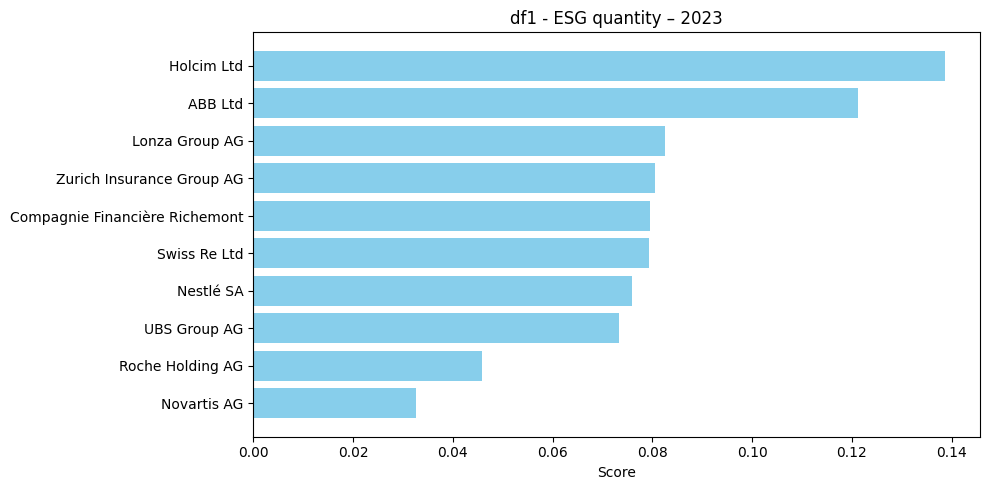

In [73]:
# To visualize simple ESG score (from df1)
plot_esg_scores(df1, year=2023, title='df1 - ESG quantity')

Method 2 – SASB-Weighted ESG Score

In [60]:
df2 = df1.merge(df_sasb, on='company', how='left')
df2['E_score'] *= df2['Hybrid E']
df2['S_score'] *= df2['Hybrid S']
df2['G_score'] *= df2['Hybrid G']
df2['ESG_total'] = df2[['E_score', 'S_score', 'G_score']].sum(axis=1)

df2.head(30)


,company,year,is_env,is_soc,is_gov,total_sentences,E_score,S_score,G_score,ESG_total,Hybrid E,Hybrid S,Hybrid G
0,ABB Ltd,2021,604,370,133,5060,0.067669,0.015860,0.005701,0.089231,0.5669,0.2169,0.2169
1,ABB Ltd,2022,839,561,95,4543,0.104695,0.026784,0.004536,0.136015,0.5669,0.2169,0.2169
2,ABB Ltd,2023,1079,774,126,5438,0.112483,0.030872,0.005026,0.148381,0.5669,0.2169,0.2169
3,Compagnie Financière Richemont,2021,574,923,164,6354,0.009034,0.082349,0.008597,0.099981,0.1,0.5669,0.3331
4,Compagnie Financière Richemont,2022,398,674,154,5644,0.007052,0.067699,0.009089,0.083839,0.1,0.5669,0.3331
5,Compagnie Financière Richemont,2023,405,780,172,5689,0.007119,0.077726,0.010071,0.094916,0.1,0.5669,0.3331
6,Holcim Ltd,2021,694,315,167,3899,0.114735,0.014356,0.007611,0.136703,0.6446,0.1777,0.1777
7,Holcim Ltd,2022,1027,318,197,5455,0.121357,0.010359,0.006417,0.138134,0.6446,0.1777,0.1777
8,Holcim Ltd,2023,2538,553,221,7956,0.20563,0.012351,0.004936,0.222918,0.6446,0.1777,0.1777
9,Lonza Group AG,2021,388,445,122,4319,0.008984,0.064396,0.007768,0.081147,0.1,0.6250,0.2750


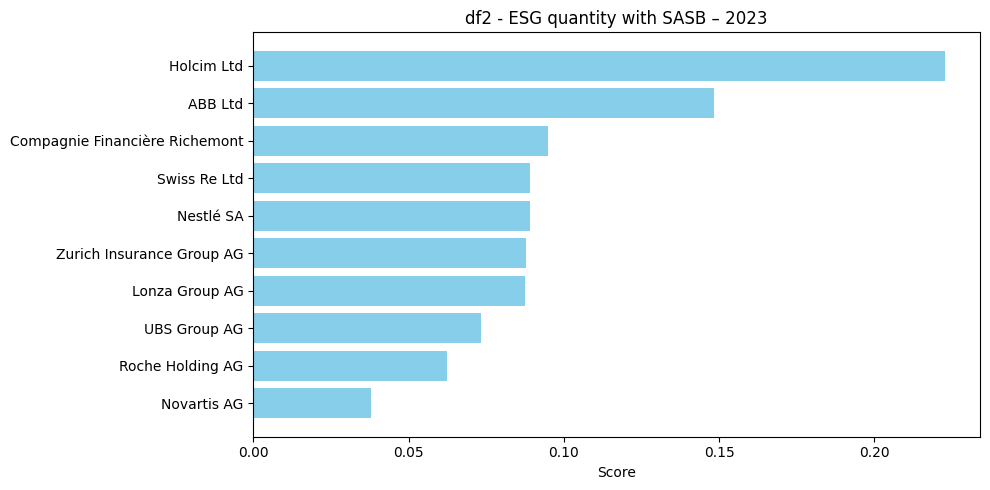

In [75]:
# To visualize simple ESG score with SASB (from df2)
plot_esg_scores(df2, year=2023, title='df2 - ESG quantity with SASB')

Method 3 – Earnings Calls Only

In [61]:
# Filter ESG-classified sentences that come from Earnings Calls
df_earn = df_esg[df_esg['document_type'].str.contains('Earnings', case=False, na=False)]

# Count ESG phrases per pillar from Earnings Calls
df_earn_count = df_earn.groupby(['company', 'year']).agg({
    'is_env': 'sum',
    'is_soc': 'sum',
    'is_gov': 'sum'
}).reset_index()

# NEW: Get total number of ALL sentences in Earnings Calls (for normalization)
df_total_earnings = df_all[df_all['document_type'].str.contains('Earnings', case=False, na=False)]
df_total_earnings = df_total_earnings.groupby(['company', 'year']).size().reset_index(name='total_earnings_sentences')

# Merge ESG counts with total sentence count from earnings calls
df3 = df_earn_count.merge(df_total_earnings, on=['company', 'year'], how='left')

# Compute ESG scores normalized by total sentences from earnings calls
df3['E_score'] = df3['is_env'] / df3['total_earnings_sentences']
df3['S_score'] = df3['is_soc'] / df3['total_earnings_sentences']
df3['G_score'] = df3['is_gov'] / df3['total_earnings_sentences']
df3['ESG_total'] = df3[['E_score', 'S_score', 'G_score']].sum(axis=1) / 3

# Show the result
df3.head(30)


,company,year,is_env,is_soc,is_gov,total_earnings_sentences,E_score,S_score,G_score,ESG_total
0,ABB Ltd,2021,64,21,0,1831,0.034954,0.011469,0.000000,0.015474
1,ABB Ltd,2022,83,32,1,1904,0.043592,0.016807,0.000525,0.020308
2,ABB Ltd,2023,79,20,1,1929,0.040954,0.010368,0.000518,0.017280
3,Compagnie Financière Richemont,2021,17,42,0,1246,0.013644,0.033708,0.000000,0.015784
4,Compagnie Financière Richemont,2022,42,75,1,1447,0.029026,0.051831,0.000691,0.027183
5,Compagnie Financière Richemont,2023,26,78,1,1397,0.018611,0.055834,0.000716,0.025054
6,Holcim Ltd,2021,75,9,0,478,0.156904,0.018828,0.000000,0.058577
7,Holcim Ltd,2022,176,29,3,1794,0.098105,0.016165,0.001672,0.038647
8,Holcim Ltd,2023,235,53,1,2288,0.102710,0.023164,0.000437,0.042104
9,Lonza Group AG,2021,19,16,0,891,0.021324,0.017957,0.000000,0.013094


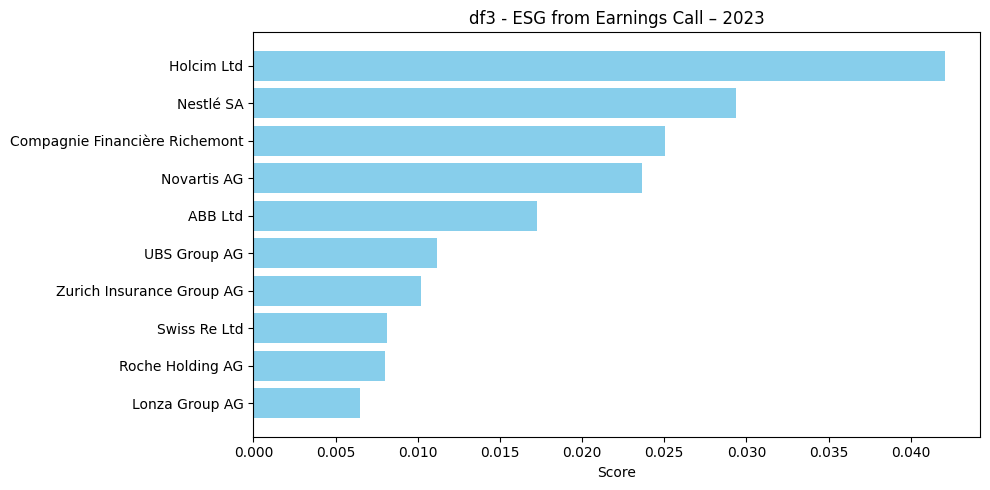

In [76]:
# To visualize  ESG score from Earnings Call (from df3)
plot_esg_scores(df3, year=2023, title='df3 - ESG from Earnings Call')

SASB-weighted version:

In [62]:
df4 = df3.merge(df_sasb, on='company', how='left')
df4['E_score'] *= df4['Hybrid E']
df4['S_score'] *= df4['Hybrid S']
df4['G_score'] *= df4['Hybrid G']
df4['ESG_total'] = df4[['E_score', 'S_score', 'G_score']].sum(axis=1)

df4.head(30)


,company,year,is_env,is_soc,is_gov,total_earnings_sentences,E_score,S_score,G_score,ESG_total,Hybrid E,Hybrid S,Hybrid G
0,ABB Ltd,2021,64,21,0,1831,0.019815,0.002488,0.000000,0.022303,0.5669,0.2169,0.2169
1,ABB Ltd,2022,83,32,1,1904,0.024713,0.003645,0.000114,0.028472,0.5669,0.2169,0.2169
2,ABB Ltd,2023,79,20,1,1929,0.023217,0.002249,0.000112,0.025578,0.5669,0.2169,0.2169
3,Compagnie Financière Richemont,2021,17,42,0,1246,0.001364,0.019109,0.000000,0.020473,0.1,0.5669,0.3331
4,Compagnie Financière Richemont,2022,42,75,1,1447,0.002903,0.029383,0.000230,0.032516,0.1,0.5669,0.3331
5,Compagnie Financière Richemont,2023,26,78,1,1397,0.001861,0.031652,0.000238,0.033752,0.1,0.5669,0.3331
6,Holcim Ltd,2021,75,9,0,478,0.10114,0.003346,0.000000,0.104486,0.6446,0.1777,0.1777
7,Holcim Ltd,2022,176,29,3,1794,0.063238,0.002873,0.000297,0.066408,0.6446,0.1777,0.1777
8,Holcim Ltd,2023,235,53,1,2288,0.066207,0.004116,0.000078,0.070401,0.6446,0.1777,0.1777
9,Lonza Group AG,2021,19,16,0,891,0.002132,0.011223,0.000000,0.013356,0.1,0.6250,0.2750


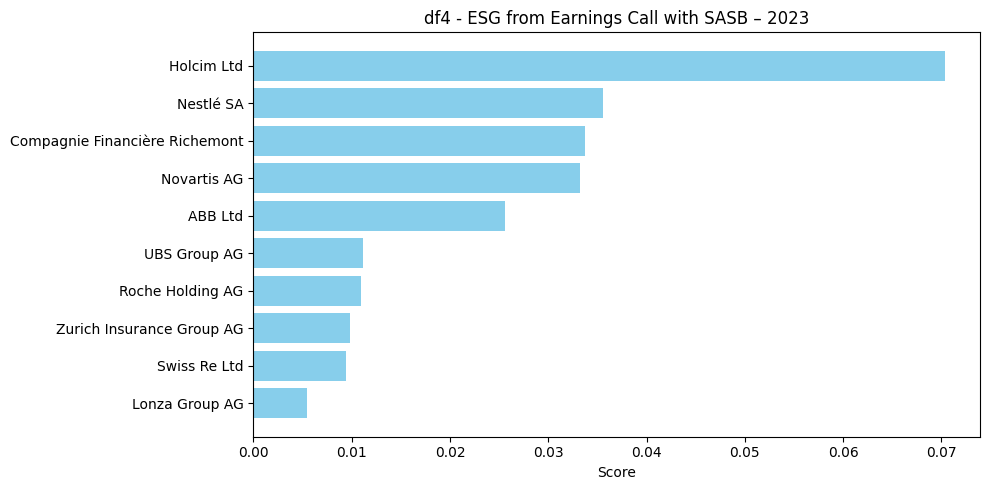

In [77]:
# To visualize  ESG score from Earnings Call with SASB (from df4)
plot_esg_scores(df4, year=2023, title='df4 - ESG from Earnings Call with SASB')

Method 4 – Earnings + Annual + Half-Year Reports

In [63]:
# Step 1: Filter df_all (all sentences) to only keep relevant documents
mask_docs = df_all['document_type'].str.contains(
    'Earnings|Annual Report|Integrated Report|Half-Year', case=False, na=False
)
df_all_imp = df_all[mask_docs].copy()

# Step 2: Identify which company-year combinations have an Annual Report
df_annual = df_all[df_all['document_type'].str.contains('Annual Report', case=False, na=False)]
annual_present = df_annual[['company', 'year']].drop_duplicates()
annual_present['has_annual'] = True

# Step 3: Add this info to df_all_imp
df_all_imp = df_all_imp.merge(annual_present, on=['company', 'year'], how='left')

# Step 4: Exclude Integrated Reports where Annual Report is present
mask_valid = ~(
    df_all_imp['document_type'].str.contains('Integrated Report', case=False, na=False) &
    df_all_imp['has_annual'].fillna(False)
)
df_all_imp_final = df_all_imp[mask_valid].copy()

# Step 5: Recalculate total sentences just for these selected documents
df_total_imp = df_all_imp_final.groupby(['company', 'year']).size().reset_index(name='total_sentences')

# Step 6: Apply same logic to ESG-classified sentences
df_esg_imp = df_esg[df_esg['document_type'].isin(df_all_imp_final['document_type'].unique())].copy()
df_esg_imp = df_esg_imp.merge(annual_present, on=['company', 'year'], how='left')
df_esg_imp = df_esg_imp[~(
    df_esg_imp['document_type'].str.contains('Integrated Report', case=False, na=False) &
    df_esg_imp['has_annual'].fillna(False)
)]

# Step 7: Count ESG-classified sentences per pillar
df_imp_count = df_esg_imp.groupby(['company', 'year']).agg({
    'is_env': 'sum', 'is_soc': 'sum', 'is_gov': 'sum'
}).reset_index()

# Step 8: Merge ESG counts with total sentences
df5 = df_imp_count.merge(df_total_imp, on=['company', 'year'], how='left')

# Step 9: Calculate normalized ESG scores
df5['E_score'] = df5['is_env'] / df5['total_sentences']
df5['S_score'] = df5['is_soc'] / df5['total_sentences']
df5['G_score'] = df5['is_gov'] / df5['total_sentences']
df5['ESG_total'] = df5[['E_score', 'S_score', 'G_score']].sum(axis=1) / 3

# Display result
df5.head(30)


/tmp/ipython-input-63-636073696.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_imp['has_annual'].fillna(False)
/tmp/ipython-input-63-636073696.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_esg_imp['has_annual'].fillna(False)


,company,year,is_env,is_soc,is_gov,total_sentences,E_score,S_score,G_score,ESG_total
0,ABB Ltd,2021,288,106,121,4211,0.068392,0.025172,0.028734,0.040766
1,ABB Ltd,2022,389,256,27,3023,0.128680,0.084684,0.008932,0.074099
2,ABB Ltd,2023,376,270,30,3119,0.120551,0.086566,0.009618,0.072245
3,Compagnie Financière Richemont,2021,75,179,121,4169,0.017990,0.042936,0.029024,0.029983
4,Compagnie Financière Richemont,2022,133,245,124,4416,0.030118,0.055480,0.028080,0.037893
5,Compagnie Financière Richemont,2023,103,256,120,4291,0.024004,0.059660,0.027966,0.037210
6,Holcim Ltd,2021,575,238,164,3609,0.159324,0.065946,0.045442,0.090237
7,Holcim Ltd,2022,913,242,191,5165,0.176767,0.046854,0.036980,0.086867
8,Holcim Ltd,2023,1786,515,221,6992,0.255435,0.073656,0.031608,0.120233
9,Lonza Group AG,2021,95,153,100,3297,0.028814,0.046406,0.030331,0.035184


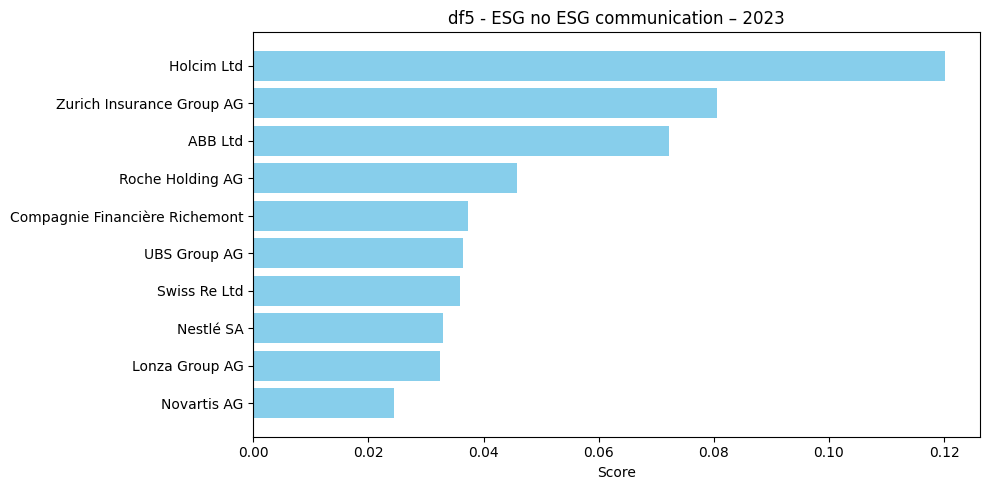

In [78]:
# To visualize  ESG no ESG communication (from df5)
plot_esg_scores(df5, year=2023, title='df5 - ESG no ESG communication')

SASB-weighted version:

In [64]:
df6 = df5.merge(df_sasb, on='company', how='left')
df6['E_score'] *= df6['Hybrid E']
df6['S_score'] *= df6['Hybrid S']
df6['G_score'] *= df6['Hybrid G']
df6['ESG_total'] = df6[['E_score', 'S_score', 'G_score']].sum(axis=1)

df6.head(30)


,company,year,is_env,is_soc,is_gov,total_sentences,E_score,S_score,G_score,ESG_total,Hybrid E,Hybrid S,Hybrid G
0,ABB Ltd,2021,288,106,121,4211,0.038772,0.005460,0.006232,0.050464,0.5669,0.2169,0.2169
1,ABB Ltd,2022,389,256,27,3023,0.072949,0.018368,0.001937,0.093254,0.5669,0.2169,0.2169
2,ABB Ltd,2023,376,270,30,3119,0.068341,0.018776,0.002086,0.089203,0.5669,0.2169,0.2169
3,Compagnie Financière Richemont,2021,75,179,121,4169,0.001799,0.024340,0.009668,0.035807,0.1,0.5669,0.3331
4,Compagnie Financière Richemont,2022,133,245,124,4416,0.003012,0.031452,0.009353,0.043817,0.1,0.5669,0.3331
5,Compagnie Financière Richemont,2023,103,256,120,4291,0.0024,0.033821,0.009315,0.045537,0.1,0.5669,0.3331
6,Holcim Ltd,2021,575,238,164,3609,0.1027,0.011719,0.008075,0.122494,0.6446,0.1777,0.1777
7,Holcim Ltd,2022,913,242,191,5165,0.113944,0.008326,0.006571,0.128841,0.6446,0.1777,0.1777
8,Holcim Ltd,2023,1786,515,221,6992,0.164653,0.013089,0.005617,0.183359,0.6446,0.1777,0.1777
9,Lonza Group AG,2021,95,153,100,3297,0.002881,0.029004,0.008341,0.040226,0.1,0.6250,0.2750


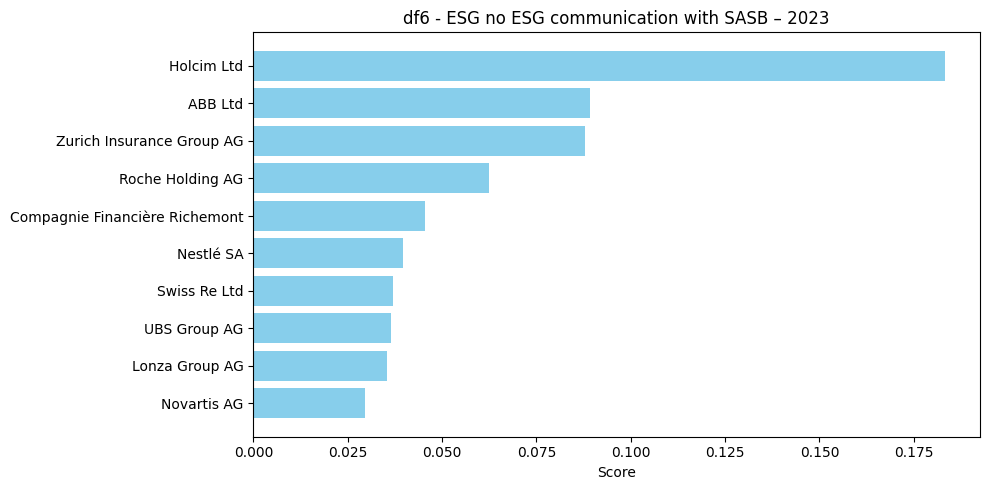

In [79]:
# To visualize ESG no ESG communication with SASB (from df6)
plot_esg_scores(df6, year=2023, title='df6 - ESG no ESG communication with SASB')

Method 5 – All Other Documents (Excluding Earnings/Annual/Half-Year)

Method 6 – Net Positive-Negative per ESG Pillar

In [65]:
def net_score(df, label):
    # Filter only rows with the correct lowercase label
    df_label = df[df['label_dominant'] == label]

    # Count positive phrases
    pos = df_label[df_label['is_pos']].groupby(['company', 'year']).size().reset_index(name='pos')

    # Count negative phrases
    neg = df_label[df_label['is_neg']].groupby(['company', 'year']).size().reset_index(name='neg')

    # Count total labeled phrases
    total = df_label.groupby(['company', 'year']).size().reset_index(name='total')

    # Merge counts
    merged = total.merge(pos, on=['company', 'year'], how='left') \
                  .merge(neg, on=['company', 'year'], how='left')

    # Replace NaNs with 0
    merged[['pos', 'neg']] = merged[['pos', 'neg']].fillna(0)

    # Compute net score
    col_name = f'{label[0].upper()}_net'
    merged[col_name] = (merged['pos'] - merged['neg']) / merged['total']

    return merged[['company', 'year', col_name]]



In [66]:
net_env = net_score(df_esg, 'environmental')
net_soc = net_score(df_esg, 'social')
net_gov = net_score(df_esg, 'governance')

In [81]:
df7 = net_env.merge(net_soc, on=['company', 'year'], how='outer') \
                .merge(net_gov, on=['company', 'year'], how='outer')

df7[['E_net', 'S_net', 'G_net']] = df7[['E_net', 'S_net', 'G_net']].fillna(0)
df7['ESG_total'] = df7[['E_net', 'S_net', 'G_net']].sum(axis=1) / 3

df7.head(30)


,company,year,E_net,S_net,G_net,ESG_total
0,ABB Ltd,2021,0.798013,0.786486,0.203008,0.595836
1,ABB Ltd,2022,0.727056,0.819964,0.326316,0.624445
2,ABB Ltd,2023,0.683040,0.723514,0.301587,0.569380
3,Compagnie Financière Richemont,2021,0.719512,0.806067,0.250000,0.591860
4,Compagnie Financière Richemont,2022,0.695980,0.810089,0.240260,0.582110
5,Compagnie Financière Richemont,2023,0.595062,0.697436,0.290698,0.527732
6,Holcim Ltd,2021,0.659942,0.679365,0.239521,0.526276
7,Holcim Ltd,2022,0.755599,0.625786,0.243655,0.541680
8,Holcim Ltd,2023,0.698188,0.701627,0.253394,0.551070
9,Lonza Group AG,2021,0.533505,0.851685,0.229508,0.538233


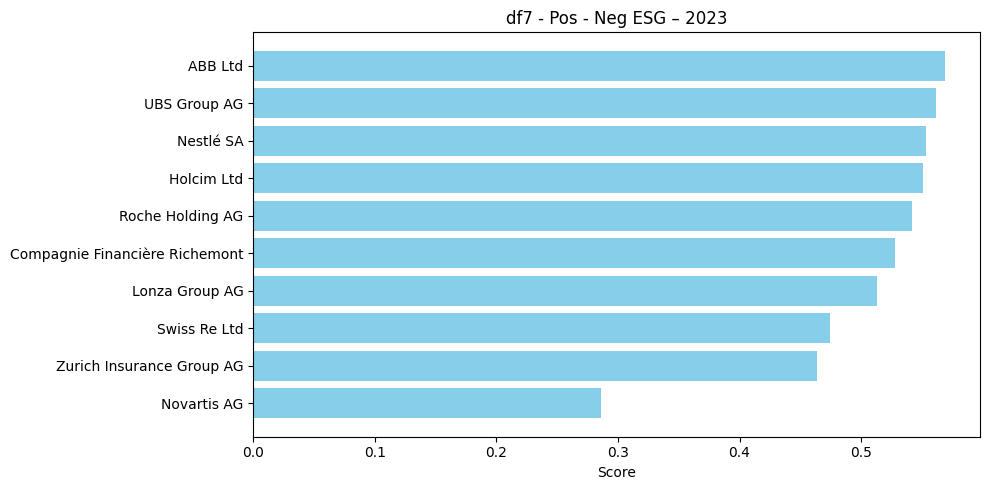

In [82]:
# To visualize Pos - Neg ESG (from df7)
plot_esg_scores(df7, year=2023, title='df7 - Pos - Neg ESG')

SASB-weighted version:


In [83]:
df8 = df7.merge(df_sasb, on='company', how='left')
df8['E_net'] *= df8['Hybrid E']
df8['S_net'] *= df8['Hybrid S']
df8['G_net'] *= df8['Hybrid G']
df8['ESG_total'] = df8[['E_net', 'S_net', 'G_net']].sum(axis=1)

df8.head(30)


,company,year,E_net,S_net,G_net,ESG_total,Hybrid E,Hybrid S,Hybrid G
0,ABB Ltd,2021,0.452394,0.170589,0.044032,0.667015,0.5669,0.2169,0.2169
1,ABB Ltd,2022,0.412168,0.177850,0.070778,0.660796,0.5669,0.2169,0.2169
2,ABB Ltd,2023,0.387215,0.156930,0.065414,0.60956,0.5669,0.2169,0.2169
3,Compagnie Financière Richemont,2021,0.071951,0.456959,0.083275,0.612186,0.1,0.5669,0.3331
4,Compagnie Financière Richemont,2022,0.069598,0.459239,0.080031,0.608868,0.1,0.5669,0.3331
5,Compagnie Financière Richemont,2023,0.059506,0.395376,0.096831,0.551714,0.1,0.5669,0.3331
6,Holcim Ltd,2021,0.425399,0.120723,0.042563,0.588685,0.6446,0.1777,0.1777
7,Holcim Ltd,2022,0.487059,0.111202,0.043297,0.641559,0.6446,0.1777,0.1777
8,Holcim Ltd,2023,0.450052,0.124679,0.045028,0.619759,0.6446,0.1777,0.1777
9,Lonza Group AG,2021,0.053351,0.532303,0.063115,0.648769,0.1,0.6250,0.2750


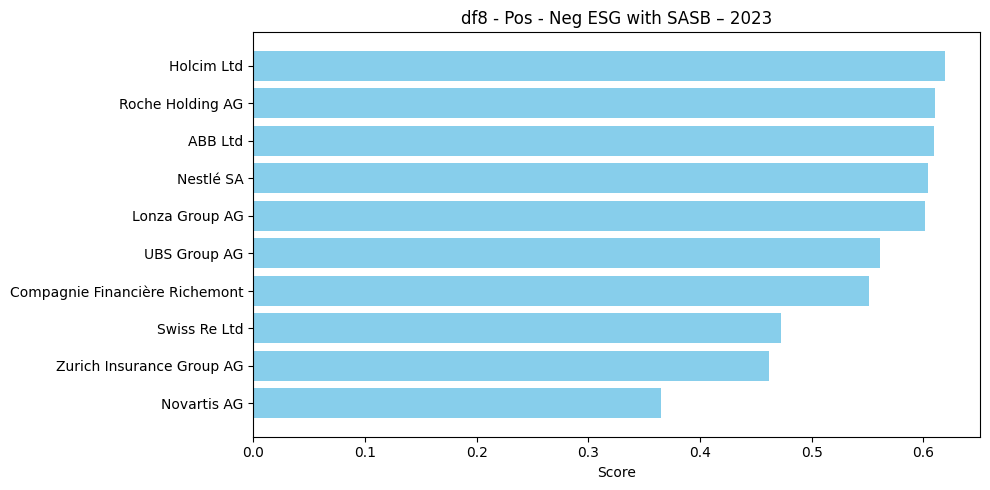

In [84]:
# To visualize Pos - Neg ESG with SASB (from df8)
plot_esg_scores(df8, year=2023, title='df8 - Pos - Neg ESG with SASB')

Method 7 – Positive ESG Proportion per Pillar

In [85]:
def pos_score(df, label):
    """
    Computes the ratio of positive sentences to total ESG sentences for a given pillar (label).
    """
    # Filter rows with the correct lowercase label
    df_label = df[df['label_dominant'] == label]

    # Count positive phrases
    pos = df_label[df_label['is_pos']].groupby(['company', 'year']).size().reset_index(name='pos')

    # Count total labeled phrases
    total = df_label.groupby(['company', 'year']).size().reset_index(name='total')

    # Merge counts
    merged = total.merge(pos, on=['company', 'year'], how='left')

    # Replace NaNs with 0
    merged['pos'] = merged['pos'].fillna(0)

    # Compute positive ratio
    col_name = f'{label[0].upper()}_pos_ratio'
    merged[col_name] = merged['pos'] / merged['total']

    return merged[['company', 'year', col_name]]


In [87]:
# Compute per-pillar positive ratios
pos_env = pos_score(df_esg, 'environmental')
pos_soc = pos_score(df_esg, 'social')
pos_gov = pos_score(df_esg, 'governance')

# Merge into single DataFrame
df9 = pos_env.merge(pos_soc, on=['company', 'year'], how='outer') \
             .merge(pos_gov, on=['company', 'year'], how='outer')

# Fill NaNs with 0 (assumes missing = no data)
df9[['E_pos_ratio', 'S_pos_ratio', 'G_pos_ratio']] = df9[['E_pos_ratio', 'S_pos_ratio', 'G_pos_ratio']].fillna(0)

# Standardized ESG score (equal weight)
df9['ESG_total'] = df9[['E_pos_ratio', 'S_pos_ratio', 'G_pos_ratio']].sum(axis=1) / 3

df9.head(30)

,company,year,E_pos_ratio,S_pos_ratio,G_pos_ratio,ESG_total
0,ABB Ltd,2021,0.827815,0.800000,0.225564,0.617793
1,ABB Ltd,2022,0.767580,0.832442,0.326316,0.642113
2,ABB Ltd,2023,0.721038,0.766150,0.357143,0.614777
3,Compagnie Financière Richemont,2021,0.735192,0.817985,0.262195,0.605124
4,Compagnie Financière Richemont,2022,0.733668,0.829377,0.259740,0.607595
5,Compagnie Financière Richemont,2023,0.656790,0.705128,0.308140,0.556686
6,Holcim Ltd,2021,0.717579,0.711111,0.251497,0.560062
7,Holcim Ltd,2022,0.793574,0.666667,0.258883,0.573041
8,Holcim Ltd,2023,0.770292,0.725136,0.271493,0.588973
9,Lonza Group AG,2021,0.615979,0.853933,0.245902,0.571938


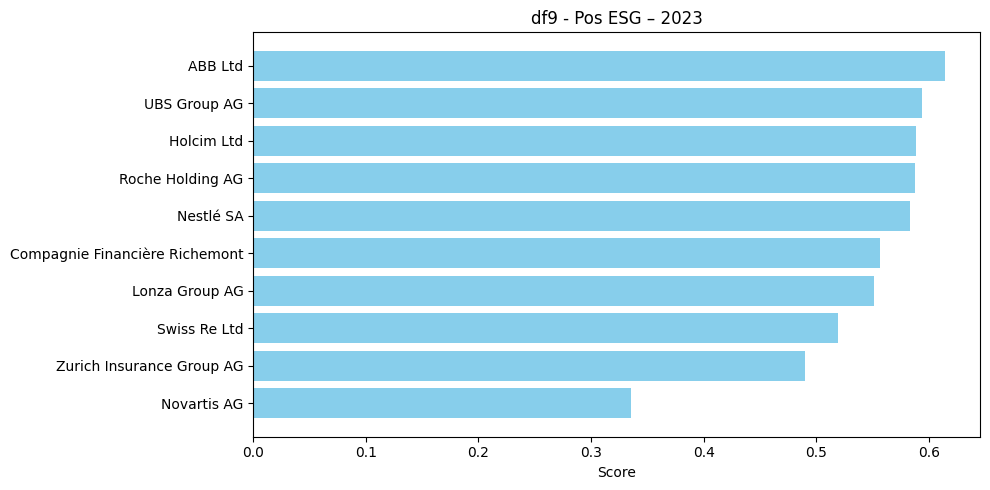

In [90]:
# To visualize Pos ESG (from df9)
plot_esg_scores(df9, year=2023, title='df9 - Pos ESG')

SASB-Weighted Version

In [89]:
df10 = df9.merge(df_sasb, on='company', how='left')

# Apply SASB weights
df10['E_pos_ratio'] *= df10['Hybrid E']
df10['S_pos_ratio'] *= df10['Hybrid S']
df10['G_pos_ratio'] *= df10['Hybrid G']

# Weighted ESG score
df10['ESG_total'] = df10[['E_pos_ratio', 'S_pos_ratio', 'G_pos_ratio']].sum(axis=1)

df10.head(30)

,company,year,E_pos_ratio,S_pos_ratio,G_pos_ratio,ESG_total,Hybrid E,Hybrid S,Hybrid G
0,ABB Ltd,2021,0.469288,0.173520,0.048925,0.691733,0.5669,0.2169,0.2169
1,ABB Ltd,2022,0.435141,0.180557,0.070778,0.686476,0.5669,0.2169,0.2169
2,ABB Ltd,2023,0.408756,0.166178,0.077464,0.652399,0.5669,0.2169,0.2169
3,Compagnie Financière Richemont,2021,0.073519,0.463716,0.087337,0.624572,0.1,0.5669,0.3331
4,Compagnie Financière Richemont,2022,0.073367,0.470174,0.086519,0.63006,0.1,0.5669,0.3331
5,Compagnie Financière Richemont,2023,0.065679,0.399737,0.102641,0.568057,0.1,0.5669,0.3331
6,Holcim Ltd,2021,0.462552,0.126364,0.044691,0.633607,0.6446,0.1777,0.1777
7,Holcim Ltd,2022,0.511537,0.118467,0.046004,0.676008,0.6446,0.1777,0.1777
8,Holcim Ltd,2023,0.49653,0.128857,0.048244,0.673631,0.6446,0.1777,0.1777
9,Lonza Group AG,2021,0.061598,0.533708,0.067623,0.662929,0.1,0.6250,0.2750


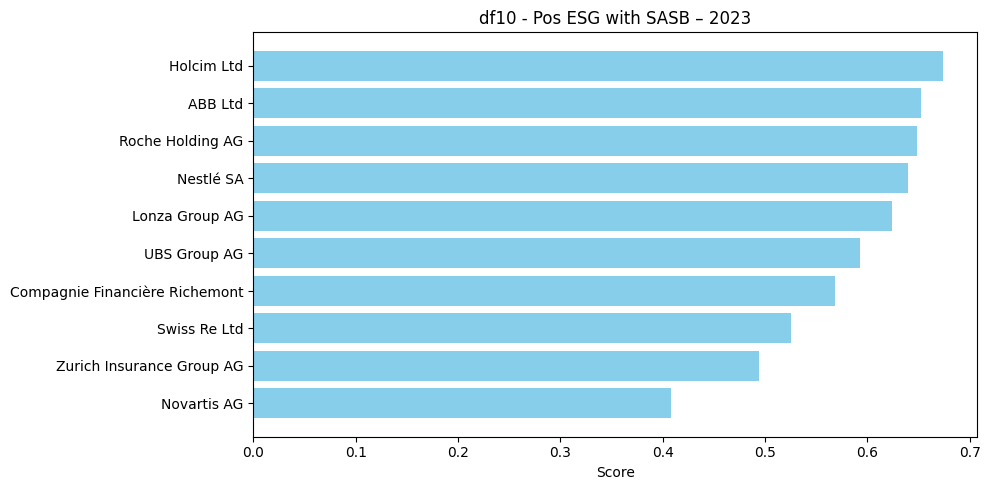

In [91]:
# To visualize Pos ESG with SASB (from df10)
plot_esg_scores(df10, year=2023, title='df10 - Pos ESG with SASB')

Now let's compare the different scores for the year 2023.

Step 1 – Prepare a mergeable subset from each DataFrame

In [92]:
# Filter and rename each ESG scoring DataFrame
df1_sub = df1[df1['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG1_quantity'})
df2_sub = df2[df2['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG2_quantity_SASB'})
df3_sub = df3[df3['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG3_earnings'})
df4_sub = df4[df4['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG4_earnings_SASB'})
df5_sub = df5[df5['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG5_nocomm'})
df6_sub = df6[df6['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG6_nocomm_SASB'})
df7_sub = df7[df7['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG7_pos_minus_neg'})
df8_sub = df8[df8['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG8_pos_minus_neg_SASB'})
df9_sub = df9[df9['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG9_pos_only'})
df10_sub = df10[df10['year'] == 2023][['company', 'ESG_total']].rename(columns={'ESG_total': 'ESG10_pos_only_SASB'})


Step 2 – Merge All into One Comparison Table

In [93]:
# Start with df1 and merge all others
df_compare = df1_sub.merge(df2_sub, on='company', how='outer') \
                    .merge(df3_sub, on='company', how='outer') \
                    .merge(df4_sub, on='company', how='outer') \
                    .merge(df5_sub, on='company', how='outer') \
                    .merge(df6_sub, on='company', how='outer') \
                    .merge(df7_sub, on='company', how='outer') \
                    .merge(df8_sub, on='company', how='outer') \
                    .merge(df9_sub, on='company', how='outer') \
                    .merge(df10_sub, on='company', how='outer')


Step 3 – Display and Explore

In [95]:
# Show all ESG scores per company for 2023
df_compare.head(20)  # You can change the number to see more rows


,company,ESG1_quantity,ESG2_quantity_SASB,ESG3_earnings,ESG4_earnings_SASB,ESG5_nocomm,ESG6_nocomm_SASB,ESG7_pos_minus_neg,ESG8_pos_minus_neg_SASB,ESG9_pos_only,ESG10_pos_only_SASB
0,ABB Ltd,0.121307,0.148381,0.017280,0.025578,0.072245,0.089203,0.569380,0.60956,0.614777,0.652399
1,Compagnie Financière Richemont,0.079510,0.094916,0.025054,0.033752,0.037210,0.045537,0.527732,0.551714,0.556686,0.568057
2,Holcim Ltd,0.138763,0.222918,0.042104,0.070401,0.120233,0.183359,0.551070,0.619759,0.588973,0.673631
3,Lonza Group AG,0.082533,0.087534,0.006464,0.005481,0.032368,0.035402,0.513495,0.601053,0.550980,0.62442
4,Nestlé SA,0.075942,0.089174,0.029352,0.035542,0.032970,0.039737,0.553628,0.604599,0.582921,0.639451
5,Novartis AG,0.032521,0.037842,0.023653,0.033236,0.024376,0.029581,0.285668,0.365136,0.335788,0.407873
6,Roche Holding AG,0.045843,0.062407,0.008033,0.011001,0.045843,0.062407,0.541992,0.610202,0.587409,0.648952
7,Swiss Re Ltd,0.079417,0.08922,0.008152,0.009385,0.035935,0.037112,0.474509,0.472239,0.519498,0.525158
8,UBS Group AG,0.073255,0.073203,0.011148,0.01114,0.036445,0.036419,0.561540,0.561147,0.593627,0.593212
9,Zurich Insurance Group AG,0.080516,0.087916,0.010172,0.009838,0.080516,0.087916,0.464005,0.462209,0.490310,0.494126
